In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

import imageio
import moviepy.editor as mpy
import os

BATCH_SIZE = 2000
SAMPLE_COL = 16
SAMPLE_ROW = 16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW
IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)
Z_DIM = 128
BUF = 20000
DC_LR = 2.5e-04
DC_EPOCH = 256
W_LR = 2.0e-04
W_EPOCH = 200
BZ = (BATCH_SIZE, Z_DIM)
WClipLo = -0.01
WClipHi = 0.01
LAMBDA = 10.0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 0x2400)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Utility function
def utPuzzle(imgs, row, col, path = None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [4]:
path = './datasets/img_align_celeba_png'

#Get file name of datasets
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.png' in file or '.PNG' in file:
            files.append(os.path.join(r, file))

In [5]:
files

['./datasets/img_align_celeba_png/053239.png',
 './datasets/img_align_celeba_png/028236.png',
 './datasets/img_align_celeba_png/136299.png',
 './datasets/img_align_celeba_png/077249.png',
 './datasets/img_align_celeba_png/101166.png',
 './datasets/img_align_celeba_png/083194.png',
 './datasets/img_align_celeba_png/074159.png',
 './datasets/img_align_celeba_png/112928.png',
 './datasets/img_align_celeba_png/013540.png',
 './datasets/img_align_celeba_png/004491.png',
 './datasets/img_align_celeba_png/113123.png',
 './datasets/img_align_celeba_png/066008.png',
 './datasets/img_align_celeba_png/085727.png',
 './datasets/img_align_celeba_png/031495.png',
 './datasets/img_align_celeba_png/199394.png',
 './datasets/img_align_celeba_png/054968.png',
 './datasets/img_align_celeba_png/020173.png',
 './datasets/img_align_celeba_png/019973.png',
 './datasets/img_align_celeba_png/043993.png',
 './datasets/img_align_celeba_png/068913.png',
 './datasets/img_align_celeba_png/127221.png',
 './datasets/

In [6]:
L = len(files)
L

202599

In [7]:
iTrain = int(L*4/4)

In [8]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMG_C)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

In [9]:
dataset_train = tf.data.Dataset.from_tensor_slices(files[:iTrain])
dataset_train = dataset_train.map(load_image)
dsTrain = dataset_train.shuffle(BUF).batch(BATCH_SIZE, True)

In [10]:
type(dsTrain)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [11]:
if not os.path.isdir('./imgs'):
    os.mkdir('./imgs')

In [12]:
def GAN(sp, zd):
    # Shape
    xh, xw, xc = sp
    zh = xh // 4
    zw = xw // 4
        
    # Model
    return keras.Sequential([
        keras.layers.Dense(units  =  1024, input_shape = (zd,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = sp,
        ),
        keras.layers.LeakyReLU(),
        #keras.layers.Dropout(0.3),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        #keras.layers.Dropout(0.3),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [13]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)
opg = keras.optimizers.Adam(W_LR)
opd = keras.optimizers.Adam(W_LR)

@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpg:
        c0 = WG(z, training = True)

        z1 = WD(c1, training = True) #d_logit_real
        z0 = WD(c0, training = True) #d_logit_fake
        
        ld = tf.reduce_mean(z0) - tf.reduce_mean(z1)
        lg = - tf.reduce_mean(z0)

    gg = tpg.gradient(lg, WG.trainable_variables)

    opg.apply_gradients(zip(gg, WG.trainable_variables))
    
    return lg, ld

@tf.function
def WDTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpd:
        c0 = WG(z, training = True)

        z1 = WD(c1, training = True) #d_logit_real
        z0 = WD(c0, training = True) #d_logit_fake

        #ld = tf.reduce_mean(z0)
        #lg = - ld
        #ld = ld - tf.reduce_mean(z1)
        
        #gradient_penalty
        alpha = tf.random.uniform(shape=[BATCH_SIZE, 1, 1, 1], minval=0., maxval=1.)
        differences = c0 - c1
        interpolates = c1 + (alpha * differences)
        gradients = tf.gradients(WD(interpolates, training = True), [interpolates])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis = [1, 2, 3]))
        gradient_penalty = tf.reduce_mean((slopes-1.)**2)
        
        ld = tf.reduce_mean(z0) - tf.reduce_mean(z1)
        ld += LAMBDA * gradient_penalty
        lg = - tf.reduce_mean(z0)

    gd = tpd.gradient(ld, WD.trainable_variables)

    opd.apply_gradients(zip(gd, WD.trainable_variables))
    for v in WD.trainable_variables : v.assign(tf.clip_by_value(v, WClipLo, WClipHi))
    
    return lg, ld

WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

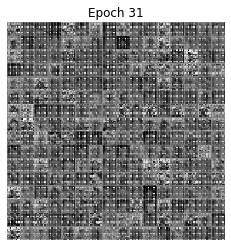

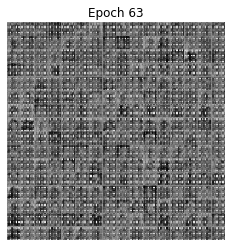

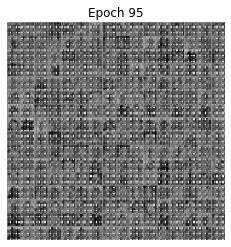

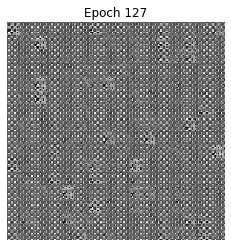

In [ ]:
wlg = [None] * W_EPOCH
wld = [None] * W_EPOCH
wsp = [None] * W_EPOCH
rsTrain = float(BATCH_SIZE) / float(iTrain)
ctr = 0
for ep in range(W_EPOCH):
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/w_%04d.png" % ep
    )
    wsp[ep] = img
    if ep & 0x1F == 0x1F:
        
        plt.imshow(img[..., 0], cmap = "gray")
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

In [ ]:
utMakeGif(np.array(wsp[:3]), "imgs/wgan.gif", duration = 2)

In [ ]:
plt.plot(range(W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN-GP Training Loss")
plt.show()